# Creator:
### Najeeb Zaidi
### Github: https://github.com/snajeebz
### zaidi.nh@gmail.com
### Contributors: 
1. https://github.com/snajeebz
2. https://github.com/qinajeeb
## Dataset Source: 
1. https://www.kaggle.com/competitions/titanic

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
from colorama import Fore, Style, init
from pprint import pprint
#Disable warning
import warnings
warnings.filterwarnings("ignore")

print(f"Tensor Flow Version: {tf.__version__}")

Tensor Flow Version: 2.13.1


In [6]:
# Color printing
# inspired by https://www.kaggle.com/code/ravi20076/sleepstate-eda-baseline
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL);
    
# inspired by https://www.kaggle.com/code/rishabh15virgo/cmi-dss-first-impression-data-understanding-eda
def summarize_dataframe(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum().values*100
    summary_df['missing%'] = (df.isna().sum().values*100)/len(df)
    summary_df['uniques'] = df.nunique().values
    summary_df['first_value'] = df.iloc[0].values
    summary_df['last_value'] = df.iloc[len(df)-1].values
    summary_df['count'] = df.count().values
    #sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    summary_df['min'] = desc['min']
    summary_df['max'] = desc['max']
    summary_df['mean'] = desc['mean']
    return summary_df

# Importing the Dataset

In [2]:
try:   #for Local Environment
    train_df = pd.read_csv("Dataset/train.csv")
    serving_df = pd.read_csv("Dataset/test.csv")
except: #for Kaggle Environment
    train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
    serving_df = pd.read_csv("/kaggle/input/titanic/test.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Strategy:
1. Data Preparation and Scikit Learn Algo implementation
2. Model and Hyper Parameter Tuning
3. Tensorflow Models implementation
4. Tensorflow Models and Hyper-Parameters Tuning

## 1. Data Preparation and Scikit Learn Algo implementation

### Steps:
1. Dataset EDA
2. Data Wrangling
3. Test Train Dataset preparation for scikit-Learn
4. Scikit Learn ML Model Plus Hyper Parameters Tuning
5. Submission of the Best Results.

## 1. Dataset EDA

In [3]:
print(train_df.describe());

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [7]:
summarize_dataframe(train_df).style.background_gradient(cmap='Purples')


,dtypes,missing#,missing%,uniques,first_value,last_value,count,min,max,mean
PassengerId,int64,0,0.000000,891,1,891,891,1.000000,891.000000,446.000000
Survived,int64,0,0.000000,2,0,0,891,0.000000,1.000000,0.383838
Pclass,int64,0,0.000000,3,3,3,891,1.000000,3.000000,2.308642
Name,object,0,0.000000,891,"Braund, Mr. Owen Harris","Dooley, Mr. Patrick",891,nan,nan,nan
Sex,object,0,0.000000,2,male,male,891,nan,nan,nan
Age,float64,17700,19.865320,88,22.000000,32.000000,714,0.420000,80.000000,29.699118
SibSp,int64,0,0.000000,7,1,0,891,0.000000,8.000000,0.523008
Parch,int64,0,0.000000,7,0,0,891,0.000000,6.000000,0.381594
Ticket,object,0,0.000000,681,A/5 21171,370376,891,nan,nan,nan
Fare,float64,0,0.000000,248,7.250000,7.750000,891,0.000000,512.329200,32.204208


In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Observations:
1. Cabin has got 687 nulls which is more than 75% of the rows. So I guess it will be better to not use cabin as a feature for our model.
2. Age has around 20% nulls. So we will try the best to fill them up.

## Let's dig deep into Age

In [5]:
print("Group by Parch: \n",train_df['Age'].isna().groupby(train_df['Parch']).value_counts())
print("Group by Sex: \n",train_df['Age'].isna().groupby(train_df['Sex']).value_counts())
print("Group by SibSp: \n",train_df['Age'].isna().groupby(train_df['SibSp']).value_counts())
print("Group by Pclass: \n",train_df['Age'].isna().groupby(train_df['Pclass']).value_counts())



Group by Parch: 
 Parch  Age  
0      False    521
       True     157
1      False    110
       True       8
2      False     68
       True      12
3      False      5
4      False      4
5      False      5
6      False      1
Name: count, dtype: int64
Group by Sex: 
 Sex     Age  
female  False    261
        True      53
male    False    453
        True     124
Name: count, dtype: int64
Group by SibSp: 
 SibSp  Age  
0      False    471
       True     137
1      False    183
       True      26
2      False     25
       True       3
3      False     12
       True       4
4      False     18
5      False      5
8      True       7
Name: count, dtype: int64
Group by Pclass: 
 Pclass  Age  
1       False    186
        True      30
2       False    173
        True      11
3       False    355
        True     136
Name: count, dtype: int64


## Observation
1. Out the Nans of age 16% are female.
2. Out the Nans of age 21% are male.

#### Let's separate the columns to impute the nulls.

In [6]:
df = train_df[['Survived','Age','SibSp', 'Parch', 'Fare','PassengerId', 'Sex','Pclass']]
df=pd.get_dummies(df, columns=['Sex'])
df.head()


,Survived,Age,SibSp,Parch,Fare,PassengerId,Pclass,Sex_female,Sex_male
0,0,22.0,1,0,7.2500,1,3,False,True
1,1,38.0,1,0,71.2833,2,1,True,False
2,1,26.0,0,0,7.9250,3,3,True,False
3,1,35.0,1,0,53.1000,4,1,True,False
4,0,35.0,0,0,8.0500,5,3,False,True


#### Separating Nans from the df

In [7]:
df.isnull().sum()

Survived         0
Age            177
SibSp            0
Parch            0
Fare             0
PassengerId      0
Pclass           0
Sex_female       0
Sex_male         0
dtype: int64

In [8]:
df_nan=df[df['Age'].isnull()]
df.dropna(inplace=True)
df.isnull().sum()


Survived       0
Age            0
SibSp          0
Parch          0
Fare           0
PassengerId    0
Pclass         0
Sex_female     0
Sex_male       0
dtype: int64

In [9]:
print('Parch',df_nan['Parch'].value_counts())
print('SibSp',df_nan['SibSp'].value_counts())


Parch Parch
0    157
2     12
1      8
Name: count, dtype: int64
SibSp SibSp
0    137
1     26
8      7
3      4
2      3
Name: count, dtype: int64


In [10]:
figure= px.imshow(df.corr(), text_auto=True, width=1200, height=1200)
figure.show()

Upper Outliers: Series([], Name: Age, dtype: float64)
Lower Outliers: Series([], Name: Age, dtype: float64)


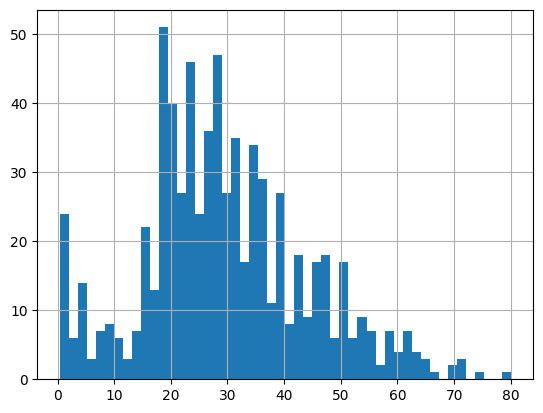

In [11]:
df['Age'].hist(bins=50)
print('Upper Outliers:',df['Age'][df['Age']>80])
print('Lower Outliers:',df['Age'][df['Age']<0])

Some noticeable correlation between Sibsp, Parch with Age. I guess if we apply Machine Learning Algorithm, we can get some fruitful model to fill the Nans of the age.

### Let's try Linear Regression to see what we can come up with.

In [12]:
df.columns

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'PassengerId', 'Pclass',
       'Sex_female', 'Sex_male'],
      dtype='object')

In [83]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

X=df[['Survived', 'SibSp', 'Parch','Fare','Sex_female', 'Sex_male','Pclass']]
y=df[['Age']]
X_train,X_test,y_train, y_test=train_test_split(X,y,train_size=0.9, random_state=42)

model = linear_model.LinearRegression()
model.fit(X_train,y_train)
print(model.get_params())
y_pred=model.predict(X_test)
print("Normal Model:",model.score(X_test,y_test))


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Normal Model: 0.20106010740500957


In [86]:
results=X_test
results=results.join(y_test)
results['Predicted Age']=y_pred
mae = mean_absolute_error(y_test,y_pred)
results
results['Parch'].describe()
mae

11.05717038487275

Group by Parch: 
 Parch
0     32.944040
1    156.554683
2     49.931123
3     56.334699
Name: percent error, dtype: float64 [0 1 3 2]
Group by Mele: 
 Sex_male
False    48.206739
True     57.581228
Name: percent error, dtype: float64
Group by Female: 
 Sex_female
False    57.581228
True     48.206739
Name: percent error, dtype: float64
Group by Pclass: 
 Pclass
1    35.152146
2    80.078957
3    51.850618
Name: percent error, dtype: float64
Values with error more than 10%: 0


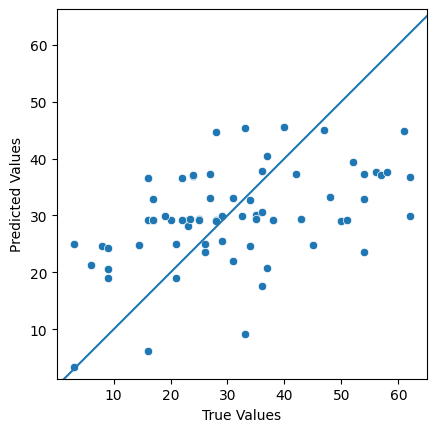

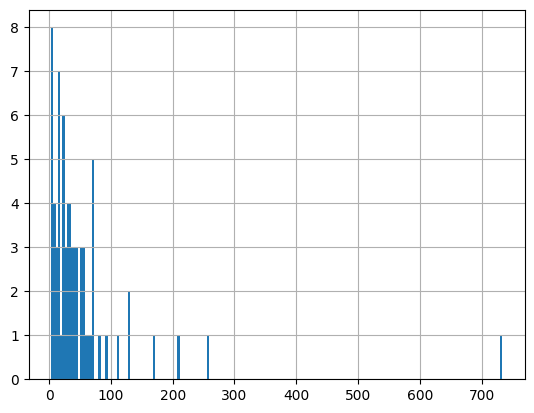

In [87]:
def plotresults(results):
    results['error']=results['Predicted Age']-results['Age']

    results['percent error']=100*results['error'].abs()/results['Age']
        
    plt.figure(1)
    sns.scatterplot(data=results, x='Age', y='Predicted Age')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100,100],[-100,100])
    plt.figure(2)
    results['percent error'].hist(bins=200)
    #plt.axis('equal')
    #plt.axis('square')
 #   plt.ylim([0,1])
plotresults(results)
results.describe()
print("Group by Parch: \n",results['percent error'].groupby(results['Parch']).mean(), results['Parch'].unique())
print("Group by Mele: \n",results['percent error'].groupby(results['Sex_male']).mean())
print("Group by Female: \n",results['percent error'].groupby(results['Sex_female']).mean())
print("Group by Pclass: \n",results['percent error'].groupby(results['Pclass']).mean())
print("Values with error more than 10%:", results['percent error'][(results['percent error']>10) & (results['percent error']< -10)].count())



In [88]:
print("Values with error more than 10%:", results['percent error'][(results['percent error'] > 10) | (results['percent error']< -10)].count())
results['percent error'].count()

Values with error more than 10%: 60


72

## Observations:
- Around 20% accurate predictions with MAE around 25%.
- Apart of rows, where Parch=3 and SibSp=3 the Mean Absolute Error is less than 10%. in df_nan this equates to less than 5 out of 177 values.
- It will be better to tryout CNN on this as well. Probably we can get better accuracy than this. 

In [95]:
model_nn=tf.keras.Sequential([
  tf.keras.layers.Dense(1281,input_shape=[len(X_train.keys())]),
  #  tf.keras.layers.Dense(1281,'''activation=tf.nn.softmax,''' input_shape=[len(X_train.keys())]),
  #  tf.keras.layers.Dense(1281,activation=tf.nn.relu, use_bias=True),
  #  tf.keras.layers.Dense(1281,activation=tf.nn.relu, use_bias=False),
  #  tf.keras.layers.Dense(512,activation=tf.nn.relu, use_bias=False),
 #   tf.keras.layers.Dense(256,activation=tf.nn.relu, use_bias=True),
    tf.keras.layers.Dense(512, activation='linear'),
 #   tf.keras.layers.Dense(256,activation=tf.nn.softmax, use_bias=True),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear'),
  #  tf.keras.layers.Dense(4,activation=tf.nn.relu, use_bias=False),
  #  tf.keras.layers.Dense(2,activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(1, activation='linear')
])
#model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001) , loss='mse', metrics=['mae','mse'])
model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001) , loss='mse', metrics=['mae','mse','accuracy'])

model_nn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 1281)              10248     
                                                                 
 dense_169 (Dense)           (None, 512)               656384    
                                                                 
 dense_170 (Dense)           (None, 128)               65664     
                                                                 
 dense_171 (Dense)           (None, 32)                4128      
                                                                 
 dense_172 (Dense)           (None, 1)                 33        
                                                                 
Total params: 736,457
Trainable params: 736,457
Non-trainable params: 0
_________________________________________________________________


## Writing function to evaluate the DL Model

In [91]:
def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist['epoch']=history.epoch
    hist1=[]
#hist1=hist.tail(550)
    hist1=hist
#sns.lineplot(data=histsamp, y='val_mse', x='epoch')

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist1['epoch'],hist1['mae'], label='Train Error')
    plt.plot(hist1['epoch'], hist1['val_mae'], label='Val_Error')
    plt.legend()
#plt.ylim([0, 0.2])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist1['epoch'],hist1['mse'], label='Train Error')
    plt.plot(hist1['epoch'], hist1['val_mse'], label='Val_Error')
    plt.legend()

Epoch 1/5000
2/2 [==============================] - 1s 332ms/step - loss: 16129.1494 - mae: 58.9845 - mse: 16129.1494 - accuracy: 0.0000e+00 - val_loss: 1258.4059 - val_mae: 32.2124 - val_mse: 1258.4059 - val_accuracy: 0.0000e+00
Epoch 2/5000
2/2 [==============================] - 0s 50ms/step - loss: 2328.9399 - mae: 30.4390 - mse: 2328.9399 - accuracy: 0.0000e+00 - val_loss: 2363.9663 - val_mae: 32.1023 - val_mse: 2363.9663 - val_accuracy: 0.1250
Epoch 3/5000
2/2 [==============================] - 0s 51ms/step - loss: 22087.0000 - mae: 47.6825 - mse: 22087.0000 - accuracy: 0.0000e+00 - val_loss: 701.8993 - val_mae: 22.3520 - val_mse: 701.8993 - val_accuracy: 0.1250
Epoch 4/5000
2/2 [==============================] - 0s 49ms/step - loss: 4036.8669 - mae: 26.6720 - mse: 4036.8669 - accuracy: 0.0000e+00 - val_loss: 622.5369 - val_mae: 22.0597 - val_mse: 622.5369 - val_accuracy: 0.1250
Epoch 5/5000
2/2 [==============================] - 0s 48ms/step - loss: 1439.7163 - mae: 30.7762 - mse

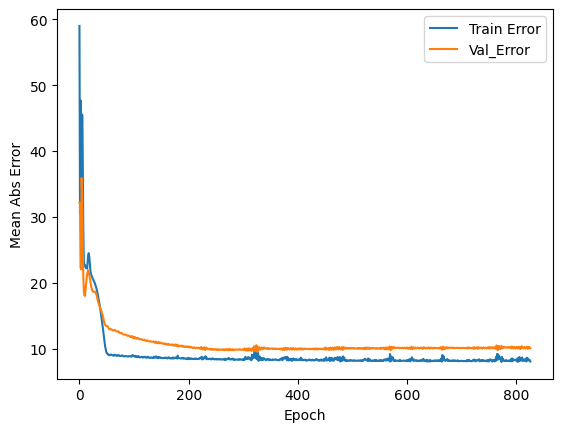

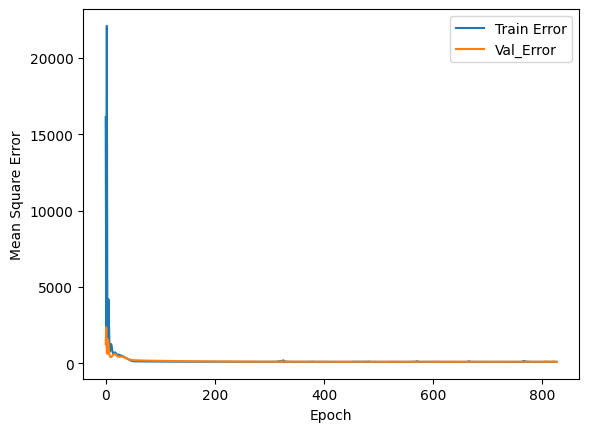

In [96]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_mae',
                                            min_delta=0,
                                            patience=500,
                                             verbose=0, mode='auto')
X_train = pd.DataFrame(X_train).astype('float32')
X_test = pd.DataFrame(X_test).astype('float32')
history=model_nn.fit(X_test,y_train, epochs=5000, validation_split=0.1, batch_size=32,callbacks=[early_stop])
#evaluate the model
print('Test accuracy:', model_nn.evaluate(X_test,y_test))
plot_history(history)


In [97]:

print('Test accuracy:', model_nn.evaluate(X_test,y_test))
y_pred1=model_nn.predict(X_test)



3/3 [==============================] - 0s 3ms/step - loss: 303.4401 - mae: 13.2852 - mse: 303.4401 - accuracy: 0.0000e+00
Test accuracy: [303.4400634765625, 13.28519058227539, 303.4400634765625, 0.0]
3/3 [==============================] - 0s 4ms/step


TypeError: 'Index' object is not callable

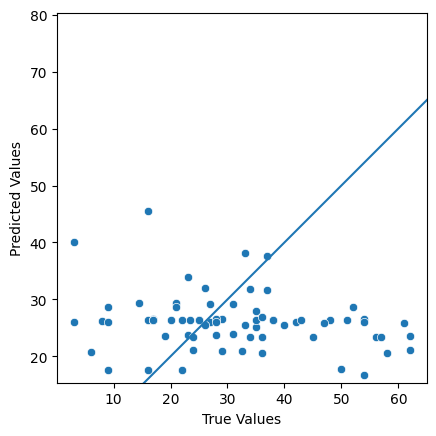

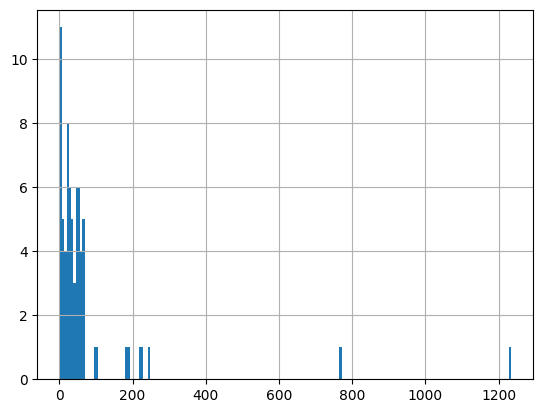

In [98]:
results1=X_test
results1=results1.join(y_test)
results1['Predicted Age']=y_pred1
results1['Predicted Age'].unique()
plotresults(results1)
results1.head(72)
results1[results1['percent error'].abs()>10].count()
results1.columns()


## Observations:
- Despite of several attempts and combinations were unable to get decent accuracy from both Machine Learning and Deep Learning models a lot can be fund in commented codes.
- If we compare both, the best results we are getting from Linear Regression ML (20% accuracy with 10 mae) when we compare it with CNN we get  maximum 14% accuracy with 11 mae)
- In addition to that if we look at the linear plot of test and predicted values, CNN results show concentration around the mean, whereas ML results show well spread predictions.
- Other options we can use to fill the missing values is by filling it with classified means.
- To me the best option available apart of deleting the 177 nans is to predict these with 20% accurate model

____________________________________________________
### Using df_nan to predict the missing values.


In [108]:
model.fit(X_test,y_test)
df_nan.head()
df_nan[['Age']]=1
df_nan = pd.DataFrame(df_nan).astype('float32')
df_nan

,Survived,Age,SibSp,Parch,Fare,PassengerId,Pclass,Sex_female,Sex_male
5,0.0,1.0,0.0,0.0,8.458300,6.0,3.0,0.0,1.0
17,1.0,1.0,0.0,0.0,13.000000,18.0,2.0,0.0,1.0
19,1.0,1.0,0.0,0.0,7.225000,20.0,3.0,1.0,0.0
26,0.0,1.0,0.0,0.0,7.225000,27.0,3.0,0.0,1.0
28,1.0,1.0,0.0,0.0,7.879200,29.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
859,0.0,1.0,0.0,0.0,7.229200,860.0,3.0,0.0,1.0
863,0.0,1.0,8.0,2.0,69.550003,864.0,3.0,1.0,0.0
868,0.0,1.0,0.0,0.0,9.500000,869.0,3.0,0.0,1.0
878,0.0,1.0,0.0,0.0,7.895800,879.0,3.0,0.0,1.0


In [109]:
X_def=df_nan[['Survived', 'SibSp', 'Parch','Fare','Sex_female', 'Sex_male','Pclass']]
X_def=np.asarray(X_def)
y_def=model.predict(X_def)
df_nan[['Age']]=y_def
df_nan.head(177)

,Survived,Age,SibSp,Parch,Fare,PassengerId,Pclass,Sex_female,Sex_male
5,0.0,27.110674,0.0,0.0,8.458300,6.0,3.0,0.0,1.0
17,1.0,32.021828,0.0,0.0,13.000000,18.0,2.0,0.0,1.0
19,1.0,27.340956,0.0,0.0,7.225000,20.0,3.0,1.0,0.0
26,0.0,27.129698,0.0,0.0,7.225000,27.0,3.0,0.0,1.0
28,1.0,27.330864,0.0,0.0,7.879200,29.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
859,0.0,27.129633,0.0,0.0,7.229200,860.0,3.0,0.0,1.0
863,0.0,7.281830,8.0,2.0,69.550003,864.0,3.0,1.0,0.0
868,0.0,27.094604,0.0,0.0,9.500000,869.0,3.0,0.0,1.0
878,0.0,27.119350,0.0,0.0,7.895800,879.0,3.0,0.0,1.0


## Adding the predicted values from df_nan into train_df

In [110]:
df_age=df_nan[['Age']]
df_age.Age[19]
df_age.index[0]
for i in df_age.index:
    print(train_df.Age[i], " = ", format(df_age.Age[i], '.1F'))
    train_df.Age[i] = format(df_age.Age[i], '.1F')

29.3  =  27.1
30.0  =  32.0
21.9  =  27.3
29.3  =  27.1
21.9  =  27.3
29.3  =  27.1
31.5  =  39.3
21.9  =  27.3
22.0  =  24.0
29.3  =  27.1
29.3  =  27.1
24.9  =  25.0
21.9  =  27.3
20.6  =  22.9
37.6  =  39.7
45.0  =  43.0
17.0  =  18.8
29.3  =  27.1
29.3  =  27.1
21.9  =  27.3
29.3  =  27.1
29.3  =  27.1
29.3  =  27.1
22.0  =  24.0
17.4  =  25.1
29.3  =  27.1
29.3  =  27.1
16.8  =  22.0
27.8  =  24.0
29.3  =  27.1
29.3  =  27.1
-6.8  =  4.0
36.6  =  39.6
45.0  =  43.0
15.7  =  17.7
-6.9  =  7.3
37.2  =  35.1
44.7  =  42.6
17.6  =  25.2
29.3  =  27.1
21.9  =  27.3
-6.8  =  4.0
25.1  =  25.1
29.3  =  27.1
15.6  =  21.0
29.2  =  30.4
24.9  =  28.3
17.6  =  25.2
29.3  =  27.1
36.8  =  42.4
29.3  =  27.1
29.2  =  30.4
45.0  =  42.9
21.9  =  27.3
37.4  =  35.3
45.0  =  43.0
45.0  =  43.0
37.7  =  39.8
21.9  =  27.3
13.3  =  19.8
29.9  =  35.3
29.3  =  27.1
36.3  =  41.9
-6.8  =  4.0
13.2  =  23.1
31.7  =  39.5
29.3  =  27.1
17.6  =  25.2
44.9  =  42.8
29.3  =  27.1
21.9  =  27.3
21.9  =  2

In [111]:
train_df['Age'].isnull().sum()

0

In [112]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    object 
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 83.7+ KB


#### Now creating a new dataset csv train_df_age.csv to proceed further.

In [106]:
train_df.to_csv('train_df_age.csv')